## Pipeline SVM: Preprocesamiento, Búsqueda de Hiperparámetros y Evaluación

En las siguientes celdas se carga el dataset limpio, se define un pipeline que incluye preprocesamiento (escalado) y un clasificador SVM, se realiza búsqueda sistemática de hiperparámetros con `GridSearchCV`, y se evalúa el mejor modelo en un set de prueba. Se guardan resultados resumidos para extraer conclusiones.

In [11]:
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, precision_recall_curve, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
TARGET_COL = 'Diabetes'
OUT_DIR = '../svm_results/'

df = pd.read_csv('../data/diabetes_train.csv') 
df_test = pd.read_csv('../data/diabetes_test.csv')


with open('../data/dictionary.json', 'r') as f:
    data_dict = json.load(f)

df.shape

(12500, 22)

In [13]:
numeric_columns = []
categorical_columns = []
ordinal_columns = []
for col, info in data_dict.items():
    if info['type'] == 'numerical':
        numeric_columns.append(col)
    elif info['type'] == 'categorical':
        categorical_columns.append(col)
    elif info['type'] == 'ordinal':
        ordinal_columns.append(col)


# 2. Creamos el procesador de columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        # ('ord', OrdinalEncoder(), ordinal_columns) 
        ('ord', StandardScaler(), ordinal_columns) # Usamos StandardScaler para variables ordinales con varias clases ya que OrdinalEncoder las deja como enteros > 1
    ]
)



In [14]:
pipe = Pipeline([
    ('preprocesor', preprocessor), 
    ('clf', SVC(probability=False)) # False para entrenar más rápido (cambiar para obtener probabilidades)
])

param_grid = {
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto', 0.1, 0.01] # Añadidos valores numéricos explícitos
}

n_combinations = len(param_grid['clf__C']) * len(param_grid['clf__kernel']) * len(param_grid['clf__gamma'])
cv_folds = 5
total_fits = n_combinations * cv_folds

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv_folds,
    scoring='f1_macro',
    # n_jobs=-1
    verbose=1
    )

In [15]:
X_train = df.drop(columns=[TARGET_COL])
y_train = df[TARGET_COL]

X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]

display(X_train.head())

,BMI,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartAttack,PhysActivity,Fruits,Veggies,...,HealthCare,Unaffordable_care,DiffWalk,Sex,GeneralHealth,MentalHealth,PhysicalHealth,Age,Education,Income
0,23.0,0,0,1,0,0,0,1,0,1,...,1,0,0,1,1,0,0,1,4,6
1,24.0,0,0,0,0,0,0,1,1,1,...,1,0,0,1,1,2,0,8,4,8
2,26.0,1,1,1,0,0,1,1,1,1,...,1,0,1,0,5,0,6,13,6,8
3,23.0,0,0,1,0,0,0,1,1,0,...,1,0,0,1,1,0,0,8,6,8
4,24.0,1,1,1,1,0,0,1,1,1,...,1,1,1,0,2,1,0,13,6,4


In [ ]:
grid.fit(X_train, y_train)

# Resultados
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

best = grid.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
grid_contour = grid_results.groupby(['clf__gamma','clf__kernel', 'clf__C']).mean()
display(grid_contour)

In [ ]:
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['max_features', 'n_estimators', 'Accuracy']
grid_pivot = grid_reset.pivot(index='max_features', columns='n_estimators')
grid_pivot

In [ ]:
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

In [ ]:
import plotly.graph_objects as go

# X and Y axes labels
layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text='n_estimators')
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text='max_features') 
            ) )

fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )

fig.update_layout(title='Hyperparameter tuning', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Hyperparameter tuning',
                  scene = dict(
                    xaxis_title='n_estimators',
                    yaxis_title='max_features',
                    zaxis_title='Accuracy'),
                  autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
print(f"\n✓ Mejores hiperparámetros encontrados:")
for param, value in grid.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\n✓ Mejor score CV (f1_macro): {grid.best_score_:.4f}")


✓ Mejores hiperparámetros encontrados:
  - clf__C: 100
  - clf__gamma: scale
  - clf__kernel: rbf

✓ Mejor score CV (f1_macro): 0.7444


In [ ]:
# Guardar CV results
print("\n[5/5] Guardando resultados...")
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.to_csv(OUT_DIR + 'gridcv_results.csv', index=False)

print(y_test.shape[0])
# Evaluación en test set
y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')


[5/5] Guardando resultados...
50736


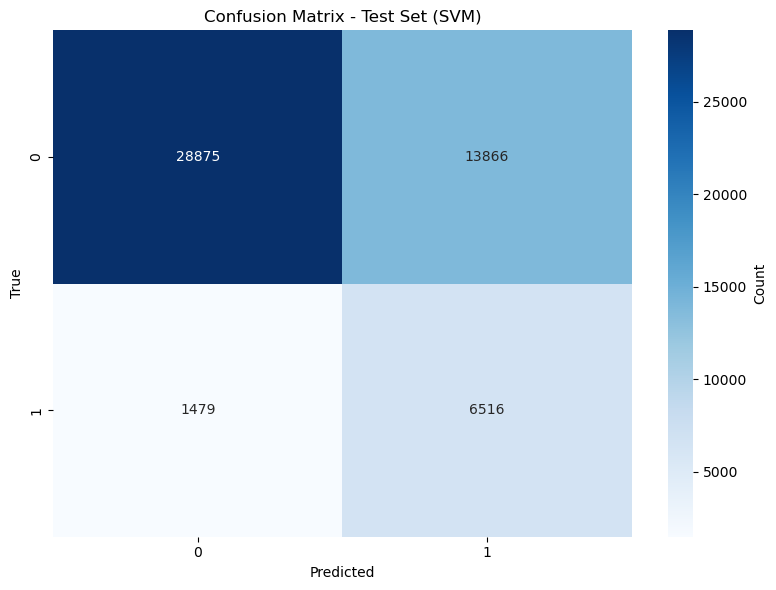

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set (SVM)')
plt.tight_layout()
plt.savefig(OUT_DIR + 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
print("\n" + "=" * 70)
print("MÉTRICAS EN CONJUNTO DE PRUEBA (TEST SET)")
print("=" * 70)
print(f"\n✓ Accuracy: {acc:.4f}")
print(f"✓ F1-Score (macro): {f1:.4f}")
print(f"\nReporte detallado por clase:")
print(classification_report(y_test, y_pred))


# Guardar resumen de métricas
summary = {
    'best_params': grid.best_params_,
    'cv_best_score_f1_macro': float(grid.best_score_),
    'test_accuracy': float(acc),
    'test_f1_macro': float(f1)
    }

with open(OUT_DIR + 'summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)


MÉTRICAS EN CONJUNTO DE PRUEBA (TEST SET)

✓ Accuracy: 0.6976
✓ F1-Score (macro): 0.6247

Reporte detallado por clase:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     42741
           2       0.32      0.82      0.46      7995

    accuracy                           0.70     50736
   macro avg       0.64      0.75      0.62     50736
weighted avg       0.85      0.70      0.74     50736

